In [1]:
# !pip install nltk
# !pip install gensim
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !pip install --upgrade numpy
# !python -m spacy download en_core_web_sm

In [2]:
import os
from os.path import isfile, join
import random
import time
import pickle
import pandas as pd
import itertools
from collections import Counter
import numpy as np
import nltk
from tqdm.notebook import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import word2vec
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
import os
import string
import re
import en_core_web_sm
import ast

In [3]:
# filePath = ["./aclImdb/train/", "./aclImdb/test/"]
# tag = ["pos/", "neg/"]
# for i in filePath:
#     for j in tag:
#         start = time.time()
#         path = i+j
#         onlyfiles = [f for f in os.listdir(path) if isfile(join(path, f))]
#         end = time.time()
#         print(f"Detect {len(onlyfiles)} files at the current path:'{path}', time: {round(end-start, 4)}s.")
# # onlyfiles

## Loading data

In [4]:
def get_df(file_path, tag, label):
    filedir = file_path + tag
    onlyfiles = [f for f in os.listdir(filedir) if isfile(join(filedir, f))]
    X = []
    y = [label] * len(onlyfiles)
    start = time.time()
    for file in tqdm(onlyfiles):
        path = filedir + file
        rating = re.findall("[0-9]+_([0-9]+).txt", file)[0]
        with open(path, "r") as f:
            contents = f.read()
            X.append([contents, rating])
    end = time.time()
    print("Time: {}s.".format(round(end- start, 4)))

    df = pd.DataFrame(X, columns = ["text", 'rating'])
    df['label'] = y
    
    return df

In [5]:
# trainPos = get_df("./aclImdb/train/", "pos/", 1)
# trainNeg = get_df("./aclImdb/train/", "neg/", 0)
# testPos = get_df("./aclImdb/test/", "pos/", 1)
# testNeg = get_df("./aclImdb/test/", "neg/", 0)

In [6]:
# train = pd.concat([trainPos, trainNeg])
# train = train.sample(frac = 1)
# train.to_csv("data/train.csv", index = False)
# train.head()

In [7]:
# test = pd.concat([testPos, testNeg])
# test = test.sample(frac = 1)
# test.to_csv("data/test.csv", index = False)
# test.head()

In [8]:
train = pd.read_csv("data/train.csv")
train.head()

,text,rating,label
0,This would have been so much fun to see in a t...,7,1
1,Playing out as a sort of pre runner to The Gre...,8,1
2,After a brief prologue showing a masked man st...,7,1
3,Liked Stanley & Iris very much. Acting was ver...,9,1
4,I was at this film's premiere at the Toronto F...,1,0


In [9]:
test = pd.read_csv("data/test.csv")
test.head()

,text,rating,label
0,It really is a great film (after being able to...,10,1
1,This movie was dreadful. Biblically very inacc...,1,0
2,I guess they reward idiocy today because whoev...,1,0
3,I really did not want to write a harsh review ...,2,0
4,"When I first saw a glimpse of this movie, I qu...",1,0


## Preprocessing 

In [10]:
# A function used to build a vocabulary based on descending word frequencies 
def build_vocab(sentences):
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

In [11]:
## A function used to learn word embeddings through Word2vec module
# def get_embeddings(inp_data, vocabulary_inv, size_features=100,
#                    mode='skipgram',
#                    min_word_count=2,
#                    context=5):
#     model_name = "embedding"
#     model_name = os.path.join(model_name) 
#     num_workers = 15  # Number of threads to run in parallel
#     downsampling = 1e-3  # Downsample setting for frequent words
#     print('Training Word2Vec model...')
#     # use inp_data and vocabulary_inv to reconstruct sentences
#     sentences = [[vocabulary_inv[w] for w in s] for s in inp_data] #??
#     if mode == 'skipgram':
#         sg = 1
#         print('Model: skip-gram')
#     elif mode == 'cbow':
#         sg = 0
#         print('Model: CBOW')
#     embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
#                                         sg=sg,
#                                         vector_size=size_features,
#                                         min_count=min_word_count,
#                                         window=context,
#                                         sample=downsampling)
#     print("Saving Word2Vec model {}".format(model_name))
#     embedding_weights = np.zeros((len(vocabulary_inv), size_features))
#     for i in range(len(vocabulary_inv)):
#         word = vocabulary_inv[i]
#         if word in embedding_model.wv:
#             embedding_weights[i] = embedding_model.wv[word]
#         else:
#             embedding_weights[i] = np.random.uniform(-0.25, 0.25,
#                                                      embedding_model.vector_size)
    
#     return embedding_weights

In [12]:
nlp_processor = en_core_web_sm.load()
stopwords = nlp_processor.Defaults.stop_words

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# return a list of tokens
def pre_processing_by_spacy(doc, lemma = True, need_sent = False):
    # Convert anything that is not character or number to be ' '
    doc = re.sub(r'[^\w\s]', ' ', doc)
    doc_class = nlp_processor(doc)
    tokens = []
    # Get sentences
    for sent in doc_class.sents:
        # Get tokens
        # Lemma
        if lemma:
            words = [token.lemma_ for token in sent]
        else:
            words = [token.text for token in sent]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
            
#     convert all tokens to be lowercase and discard those whitespaces caused by anything that is not character or number
    return [token.lower() for token in tokens if token not in stop and len(token) != 1]

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from nltk.corpus import stopwords

def preprocess_df(df):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    # prepare translation table to translate punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in tqdm(df.iterrows()):
        sent = row["text"]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    df["text"] = preprocessed_sentences
    return df

In [14]:
train = preprocess_df(train)
test = preprocess_df(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Tokenization

In [15]:
# # tokenization 
# tagged_train_data = [pre_processing_by_spacy(_d) for i, _d in enumerate(train["text"])]
# tagged_test_data = [pre_processing_by_spacy(_d) for i, _d in enumerate(test["text"])]

# # save tagged train&test data
# with open("data/tagged_train_data.txt", "w") as f:
#     for s in tqdm(tagged_train_data):
#         f.write(str(s) +"\n")
        
# with open("data/tagged_test_data.txt", "w") as f:
#     for s in tqdm(tagged_test_data):
#         f.write(str(s) +"\n")

In [16]:
# read tagged train&test data

tagged_train_data = []
with open("data/tagged_train_data.txt", "r") as f:
    for line in tqdm(f):
        tagged_train_data.append(ast.literal_eval(line.strip()))

tagged_test_data = []
with open("data/tagged_test_data.txt", "r") as f:
    for line in tqdm(f):
        tagged_test_data.append(ast.literal_eval(line.strip()))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Build vocab 

In [17]:
# build vocabulary from tokenized data
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_train_data)

# use the above mapping to create input data
inp_data = [[vocabulary[word] for word in text] for text in tagged_train_data]

### EDA for vocab and word counts

In [18]:
vocab_freqs = list(word_counts.values())
vocab_freqs.sort(reverse = True)
print("Total vocabs = {}".format(len(vocab_freqs)))

Total vocabs = 65022


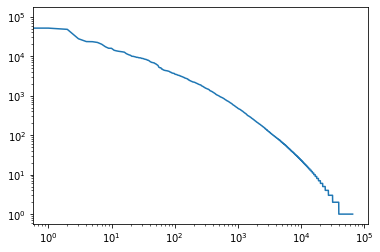

In [19]:
import matplotlib.pyplot as plt
plt.loglog(vocab_freqs)
plt.show()

In [20]:
AllVocab = sorted(word_counts.items(), key = lambda k_v: k_v[1], reverse = True)
# How many vcocabs left using frequency as filters
for i in range(16):
    print(f"{len([word for word, freq in AllVocab if freq > i])} vocabs left if frequency >= {i}")

65022 vocabs left if frequency >= 0
39174 vocabs left if frequency >= 1
31292 vocabs left if frequency >= 2
26852 vocabs left if frequency >= 3
23919 vocabs left if frequency >= 4
21818 vocabs left if frequency >= 5
20065 vocabs left if frequency >= 6
18706 vocabs left if frequency >= 7
17573 vocabs left if frequency >= 8
16618 vocabs left if frequency >= 9
15750 vocabs left if frequency >= 10
14997 vocabs left if frequency >= 11
14339 vocabs left if frequency >= 12
13705 vocabs left if frequency >= 13
13132 vocabs left if frequency >= 14
12657 vocabs left if frequency >= 15


In [21]:
sentence_length = [len(sentence) for sentence in tagged_train_data]
print(f"Average words in a sentence: {sum(sentence_length) / len(sentence_length)}")

Average words in a sentence: 123.45632


### word2vec 

In [22]:
# A function used to learn word embeddings through Word2vec module
def get_embeddings_save(inp_data, vocabulary_inv, size_features=100,
                   mode='skipgram',
                   min_word_count=2,
                   context=5,
                   save = False,
                   model_name = "word2vec",
                   negative = 5):
    
    num_workers = 15  # Number of threads to run in parallel
    downsampling = 1e-3  # Downsample setting for frequent words
    print('Training Word2Vec model...')
    # use inp_data and vocabulary_inv to reconstruct sentences
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data] #??
    if mode == 'skipgram':
        sg = 1
        print('Model: skip-gram')
    elif mode == 'cbow':
        sg = 0
        print('Model: CBOW')
    embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                        sg=sg,
                                        vector_size=size_features,
                                        min_count=min_word_count,
                                        window=context,
                                        sample=downsampling,
                                        negative=negative)
    
    # print("Saving Word2Vec model {}".format(model_name))
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25,
                                                     embedding_model.vector_size)
    if save:
        print("Saving Word2Vec model {}".format(model_name))
        model_path = "model/" + model_name + ".model"
        # model_wv_path = "model/" + model_name + ".wordvectors"
        embedding_model.save(model_path)
        # embedding_model.wv.save(model_wv_path)
    
    return embedding_weights

In [23]:
# embedding_weights = get_embeddings_save(inp_data, vocabulary_inv, model_name = "basic_sg", save = True)

# embedding_weights = get_embeddings_save(inp_data, vocabulary_inv, size_features = 300, min_word_count = 10, context = 20, negative = 10, model_name = "size300_mincount10_context20_negative10", save = True) #0.8689

# embedding_weights = get_embeddings_save(inp_data, vocabulary_inv, size_features = 300, min_word_count = 5, context = 20, negative = 10, model_name = "size300_mincount5_context20_negative10", save = True) #0.8689

# embedding_weights = get_embeddings_save(inp_data, vocabulary_inv, size_features = 500, min_word_count = 5, context = 20, negative = 10, model_name = "size500_mincount5_context20_negative10", save = True) 0.8698

# embedding_weights = get_embeddings_save(inp_data, vocabulary_inv, size_features = 700, min_word_count = 5, context = 20, negative = 10, model_name = "size700_mincount5_context20_negative10", save = True) #0.8723

# embedding_weights = get_embeddings_save(inp_data, vocabulary_inv, size_features = 1000, min_word_count = 5, context = 20, negative = 10, model_name = "size1000_mincount5_context20_negative10", save = True) #0.8732

# embedding_weights = get_embeddings_save(inp_data, vocabulary_inv, size_features = 1200, min_word_count = 5, context = 20, negative = 10, model_name = "size1200_mincount5_context20_negative10", save = True) #0.8719

# embedding_weights = get_embeddings_save(inp_data, vocabulary_inv, size_features = 1500, min_word_count = 5, context = 20, negative = 10, model_name = "size1500_mincount5_context20_negative10", save = True) #0.8742


In [24]:
def get_embeddings(model_name, vocabulary_inv, size_features=100):

    model_path = "model/" + model_name + ".model"
    embedding_model = Word2Vec.load(model_path)
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    print(f"Get embeddings for {model_name} model")
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25,
                                                     embedding_model.vector_size)
    return embedding_weights

In [25]:
# Use saved word2vec model to get embeddings
embedding_weights = get_embeddings(model_name = "size1000_mincount5_context20_negative10", vocabulary_inv = vocabulary_inv, size_features = 1000)


Get embeddings for size1000_mincount5_context20_negative10 model


In [26]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    vec = vec / len(doc)
    train_vec.append(vec)

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            continue
    vec = vec / length
    test_vec.append(vec)

In [27]:
X_train = train_vec
X_test = test_vec
y_train = np.array(train['label'])
y_test = np.array(test['label'])

## Logit

### Prediction

In [28]:
# #Grid search CV for best parameters:
# seed = 2022
# lr_grid = GridSearchCV(
#     estimator = LogisticRegression(random_state=seed, max_iter=100000000),
#     param_grid = {
#         'penalty': ['l2'],
#         'C': [0.1, 1, 10, 20, 30],
#         "solver": ['saga'],
#         'max_iter' : [100000000],
#         'random_state': [seed]
#     }, 
#     cv = 3, 
#     verbose = True,
#     scoring = ['f1_weighted', 'roc_auc_ovo'], 
#     refit = 'f1_weighted', 
#     n_jobs = -1
# )
    
# lr_grid.fit(X_train, y_train)
# print(f"Best model parameters: {lr_grid.best_params_}")
# print(f"Best scores: {lr_grid.best_score_}")

# # clf = LogisticRegression(max_iter=100000000)
# clf = LogisticRegression(**lr_grid.best_params_)
# # clf = LogisticRegression(C = 20, max_iter=100000000, penalty = 'l2', solver = 'saga', random_state = 2022)

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

In [29]:
clf = LogisticRegression(C = 10, max_iter=100000000, penalty = 'l2', solver = 'saga', random_state = 2022)
# clf = LogisticRegression(random_state = 2022)
# clf = LogisticRegression(max_iter=100000000, solver = 'saga', random_state = 2022)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

In [30]:
logit_res_dict = {"label": y_test, "pred_prob":y_pred_prob}
w2v_logit_res = pd.DataFrame(logit_res_dict)
w2v_logit_res.to_csv("w2v_logit_res.csv", index = False)

### Evaluation

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [32]:
f1_score(y_test, y_pred, average = 'macro')

0.8735065281416627

In [33]:
f1_score(y_test, y_pred, average = 'micro')

0.87352

In [34]:
accuracy_score(y_test, y_pred)

0.87352

In [35]:
y_pred_prob = clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_prob)

0.9424890431999999

## MLP

### Prediction 

In [36]:
input_shape = len(X_train[0])
n = input_shape # dim of features
m = 2 # dim of output
h1 = int(np.log2(n))
h2 = int(np.sqrt(m + n)) + 3
h3 = 2 * n + 1

clf_MLP = MLPClassifier(
    random_state = 233,
    hidden_layer_sizes = (h2, h1),
    alpha = 0.02,
    solver = 'sgd',
    max_iter = 1024,
    early_stopping = True,
    validation_fraction = 0.1,
)
clf_MLP.fit(X_train, y_train)

MLPClassifier(alpha=0.02, early_stopping=True, hidden_layer_sizes=(34, 9),
              max_iter=1024, random_state=233, solver='sgd')

In [37]:
y_pred_MLP = clf_MLP.predict(X_test)
y_pred_prob_MLP = clf_MLP.predict_proba(X_test)[:, 1]

### Evaluation 

In [38]:
f1_score(y_test, y_pred_MLP, average = 'macro')

0.8732311401750944

In [39]:
f1_score(y_test, y_pred_MLP, average = 'micro')

0.8732399999999999

In [40]:
accuracy_score(y_test, y_pred_MLP)

0.87324

In [41]:
roc_auc_score(y_test, y_pred_prob_MLP)

0.942518144

In [42]:
NN_res_dict = {"label": y_test, "pred_prob":y_pred_prob_MLP}
w2v_NN_res = pd.DataFrame(NN_res_dict)
w2v_NN_res.to_csv("w2v_NN_res.csv", index = False)